In [69]:
import numpy as np
import spectral
from PIL import Image
import os
import matplotlib.pyplot as plt
import utils
import tifffile 
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

In [101]:
## get images' directory
img1 = '/2019_04_18_M/'
img2 = '/2019_05_03_M/'

In [3]:
# get the spectral images
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
img_bands = utils.get_band(bands,img1)

# transorfm the dict into an array
def from_dict_to_array(img_bands):
    band_arrays = []
    for e in bands:
        band_arrays.append(img_bands[e])
    return band_arrays

band_arrays = from_dict_to_array(img_bands)

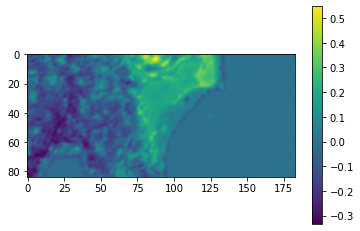

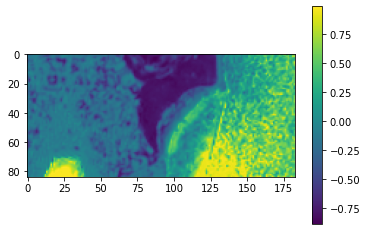

In [4]:
# plot the index

# FDI
FDI = utils.get_FDI(img1)
utils.plot_index(FDI)

# RNDVI
RNDVI = utils.get_RNDVI(img1)
utils.plot_index(RNDVI)

# size img
m,n = FDI.shape

In [5]:
def k_means_elbow_meth(arrays, ind, clust_max):
    
    arrays_flat=np.array([e[ind[0]:ind[1],ind[2]:ind[3]].flatten() for e in arrays])
    X=(np.transpose(arrays_flat))

    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(1,clust_max) 

    for k in K: 
        print(k)
        #Building and fitting the model 
        kmeans = KMeans(n_clusters=k,  init='k-means++', n_init=10, max_iter=300, random_state=0)
        kmeans.fit(X)     

        distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 
                          'euclidean'),axis=1)) / X.shape[0]) 
        inertias.append(kmeans.inertia_) 

        mapping1[k] = sum(np.min(cdist(X, kmeans.cluster_centers_, 
                     'euclidean'),axis=1)) / X.shape[0] 
        mapping2[k] = kmeans.inertia_
        
    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion') 
    plt.show()


In [35]:
def plastic_signature_kmeans(arrays, ind,nb_clust):
    m = ind[1]-ind[0]
    n = ind[3]-ind[2]
    arrays_flat=np.array([e[ind[0]:ind[1],ind[2]:ind[3]].flatten() for e in arrays])
    X=(np.transpose(arrays_flat))
    kmeans = KMeans(n_clusters=nb_clust,  init='k-means++', n_init=10, max_iter=1000) # tester k-means méthod max?
    kmeans.fit(X)
    labels=kmeans.labels_
    print(labels)
    plastic_index = 0
    nb = 99999
    nb_2 = 0
    img_labels = labels.reshape(m,n)
    plastic_index = img_labels[3,5]
    print(plastic_index)
    sea_ind = img_labels[0,0]
    print(sea_ind)
#     for i in range(nb_clust):
#         if list(labels).count(i)<nb:
#             plastic_index = i
#             nb = list(labels).count(i)
#         if list(labels).count(i)>nb_2:
#             sea_ind = i
#             nb_2 = list(labels).count(i)
#     print(i)
    plastic_sign = kmeans.cluster_centers_[plastic_index]
    sea_sign = kmeans.cluster_centers_[sea_ind]
    
    plt.figure()
    plt.imshow(img_labels)
    
    return plastic_sign, sea_sign

1
2
3
4
5
6
7
8
9


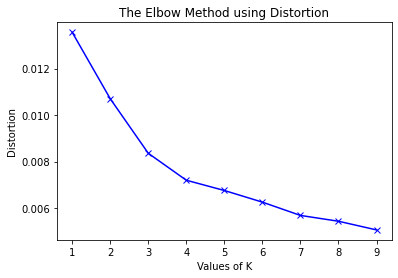

In [36]:
# array of images
ind = [39,50,120,130] # img[ind[0]:ind[1],ind[2]:ind[3]]
clust_max = 10

k_means_elbow_meth(band_arrays, ind, clust_max)


[3 3 3 3 3 0 0 1 1 1 3 3 3 3 0 0 0 0 1 1 3 3 3 0 2 2 2 0 0 1 3 3 3 0 2 2 2
 0 0 1 3 3 3 0 2 2 0 0 1 1 3 3 3 3 0 0 1 1 1 1 3 3 3 3 1 1 1 1 1 1 3 3 3 3
 1 1 1 1 1 1 3 3 3 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2
3


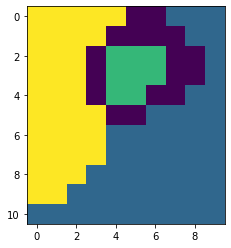

In [37]:
# plastic signature in img1

nb_clust = 4
plastic_signature1, sea_sign1 = plastic_signature_kmeans(band_arrays, ind,nb_clust)


In [38]:
print(plastic_signature1)
print(sea_sign1)

[2.4775000e-02 5.0087500e-02 3.5975002e-02 2.2662500e-02 1.1837500e-02
 1.3699999e-02 1.7637501e-02 2.5737500e-02 2.3850000e-02 9.9999997e-05
 7.5749997e-03 6.4749997e-03]
[1.5674286e-02 3.0002857e-02 2.0020001e-02 5.7999999e-03 5.8800001e-03
 4.2885714e-03 6.6828569e-03 4.6571428e-03 4.9742856e-03 9.9999997e-05
 5.2571427e-03 5.1571429e-03]


In [105]:
def predict_abundance(arrays, index_list,ind, plastic_signature, sea_sign1):
    
    BS = [arrays[i] for i in index_list]
    plastic_signature = np.array([ plastic_signature[i] for i in index_list]).reshape(len(index_list),1)
    
    sea_sign1 = np.array([ sea_sign1[i] for i in index_list]).reshape(len(index_list),1)
    

    abundance_plastic = []
    abundance_sea = []
    X = []
    for i in range(ind[0], ind[1]):
        for j in range(ind[2], ind[3]):
            x = [e[i,j] for e in BS]
            X.append(x)


    R =  np.corrcoef(np.transpose(X))
    R_inv = np.linalg.inv(R)

    for e in X:
        e = np.array(e)
        
        # sea abundance
        A = np.dot(np.transpose(sea_sign1),np.dot(R_inv,sea_sign1))
        B = np.dot(R_inv, sea_sign1)
        res = np.dot(1/A * np.transpose(B),e)
        abundance_sea.append(res)
        
        # plastic abundance
        A1 = np.dot(np.transpose(plastic_signature),np.dot(R_inv,plastic_signature))
        B1 = np.dot(R_inv, plastic_signature)
        res1 = np.dot(1/A1 * np.transpose(B1),e)
        abundance_plastic.append(res1)
        
    # sea abundance    
    plt.figure()
    plt.plot(abundance_sea)
    
    abundance = np.array(abundance_sea)
    
    sea_img_abundance = abundance.reshape(ind[1]-ind[0], ind[3]-ind[2])
#     print("sea", sea_img_abundance[30:50,60:85])
    plt.figure(figsize=(30,30))
    plt.imshow(sea_img_abundance)
    plt.colorbar()
    
    # plastic abundance 
    plt.figure()
    plt.plot(abundance_plastic)
#     print("plastic",abundance_plastic[24:30])
    abundance = np.array(abundance_plastic)
    
    plastic_img_abundance = abundance.reshape(ind[1]-ind[0], ind[3]-ind[2])
#     print("plastic", plastic_img_abundance[30:50,60:85])
    plt.figure(figsize=(30,30))
    plt.imshow(plastic_img_abundance)
    plt.colorbar()
    return plastic_img_abundance, sea_img_abundance

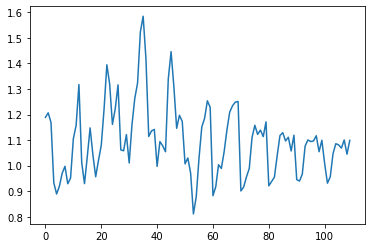

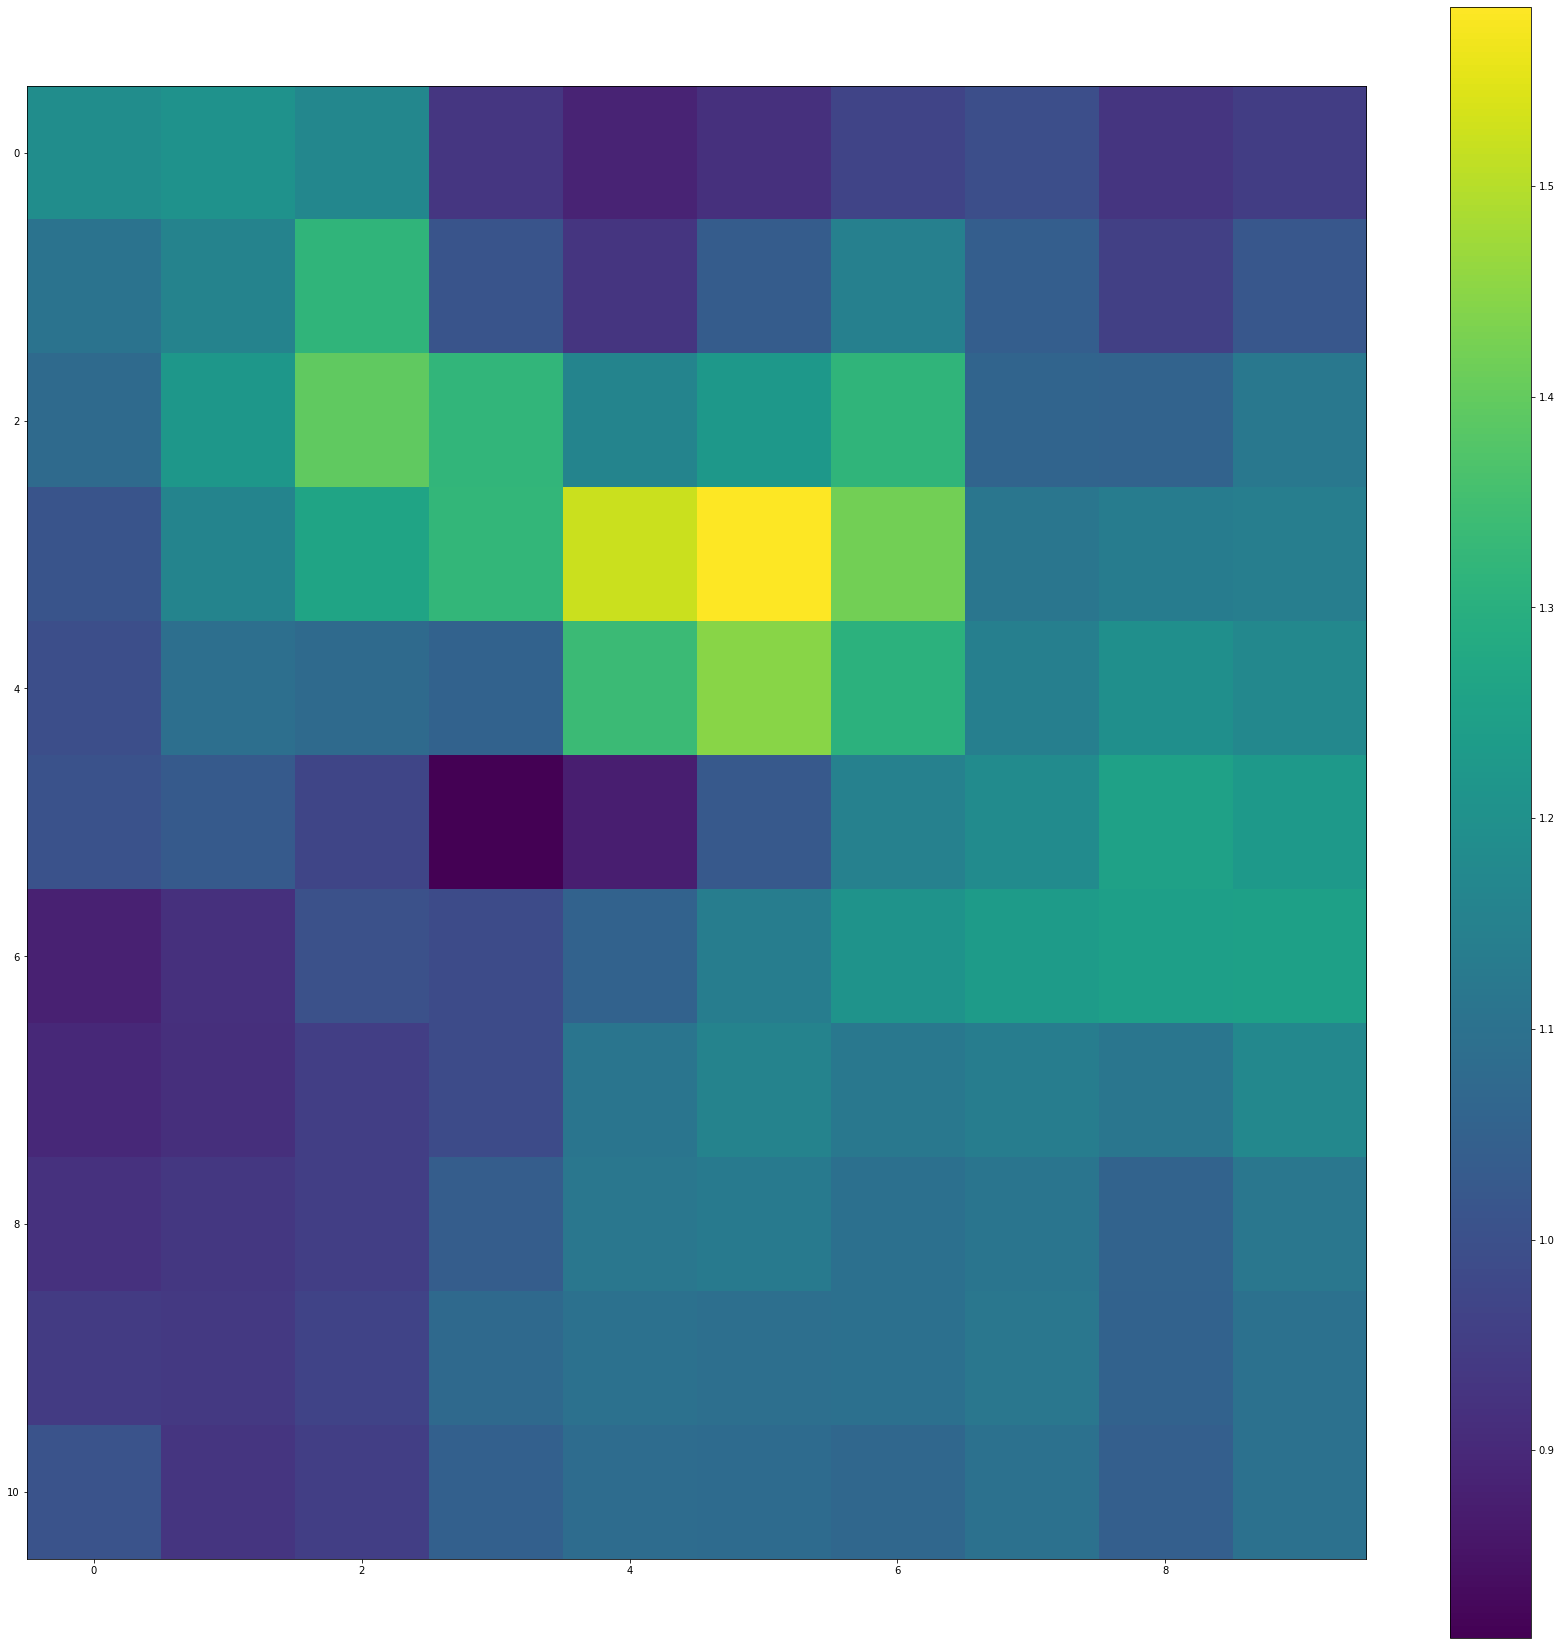

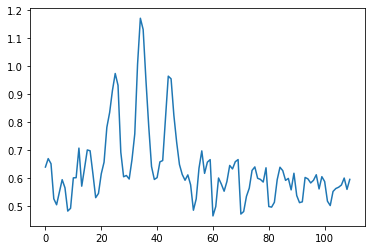

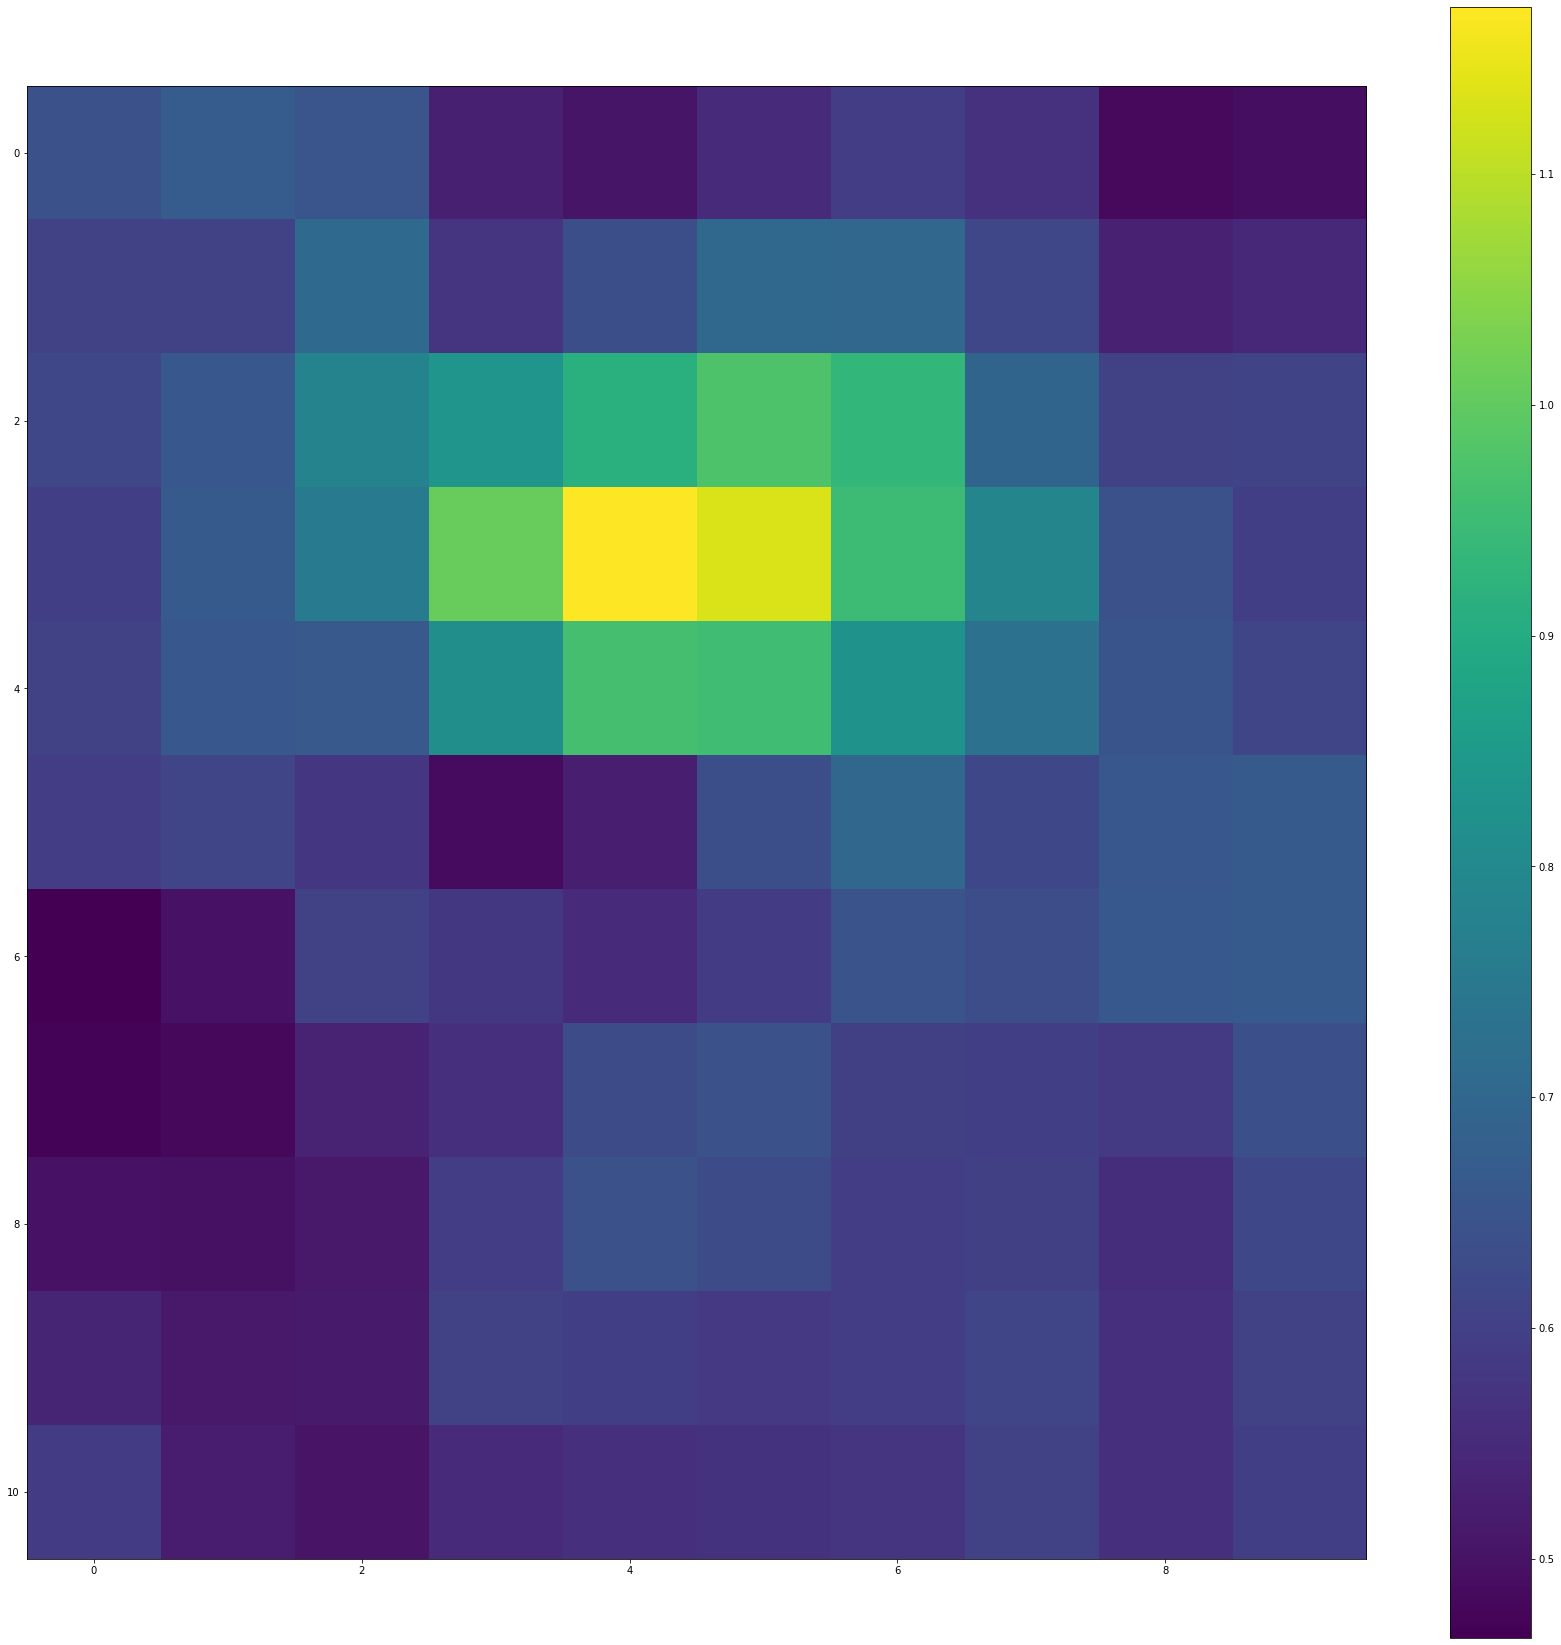

In [96]:
# prediction on a part of img1
index_list=[1,2,3,7,8]
plastic_signature_PLP = [0.0485,0.04,0.0305,0.0365,0.03525]
sea_sign_PLP = [0.034,0.028,0.014,0.013,0.012]
plastic_img_abundance, sea_img_abundance = predict_abundance(band_arrays, index_list,ind, plastic_signature_PLP, sea_sign_PLP)


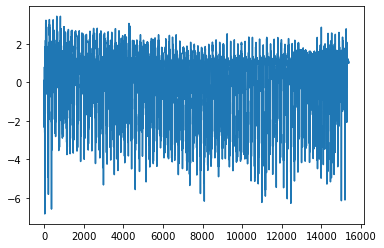

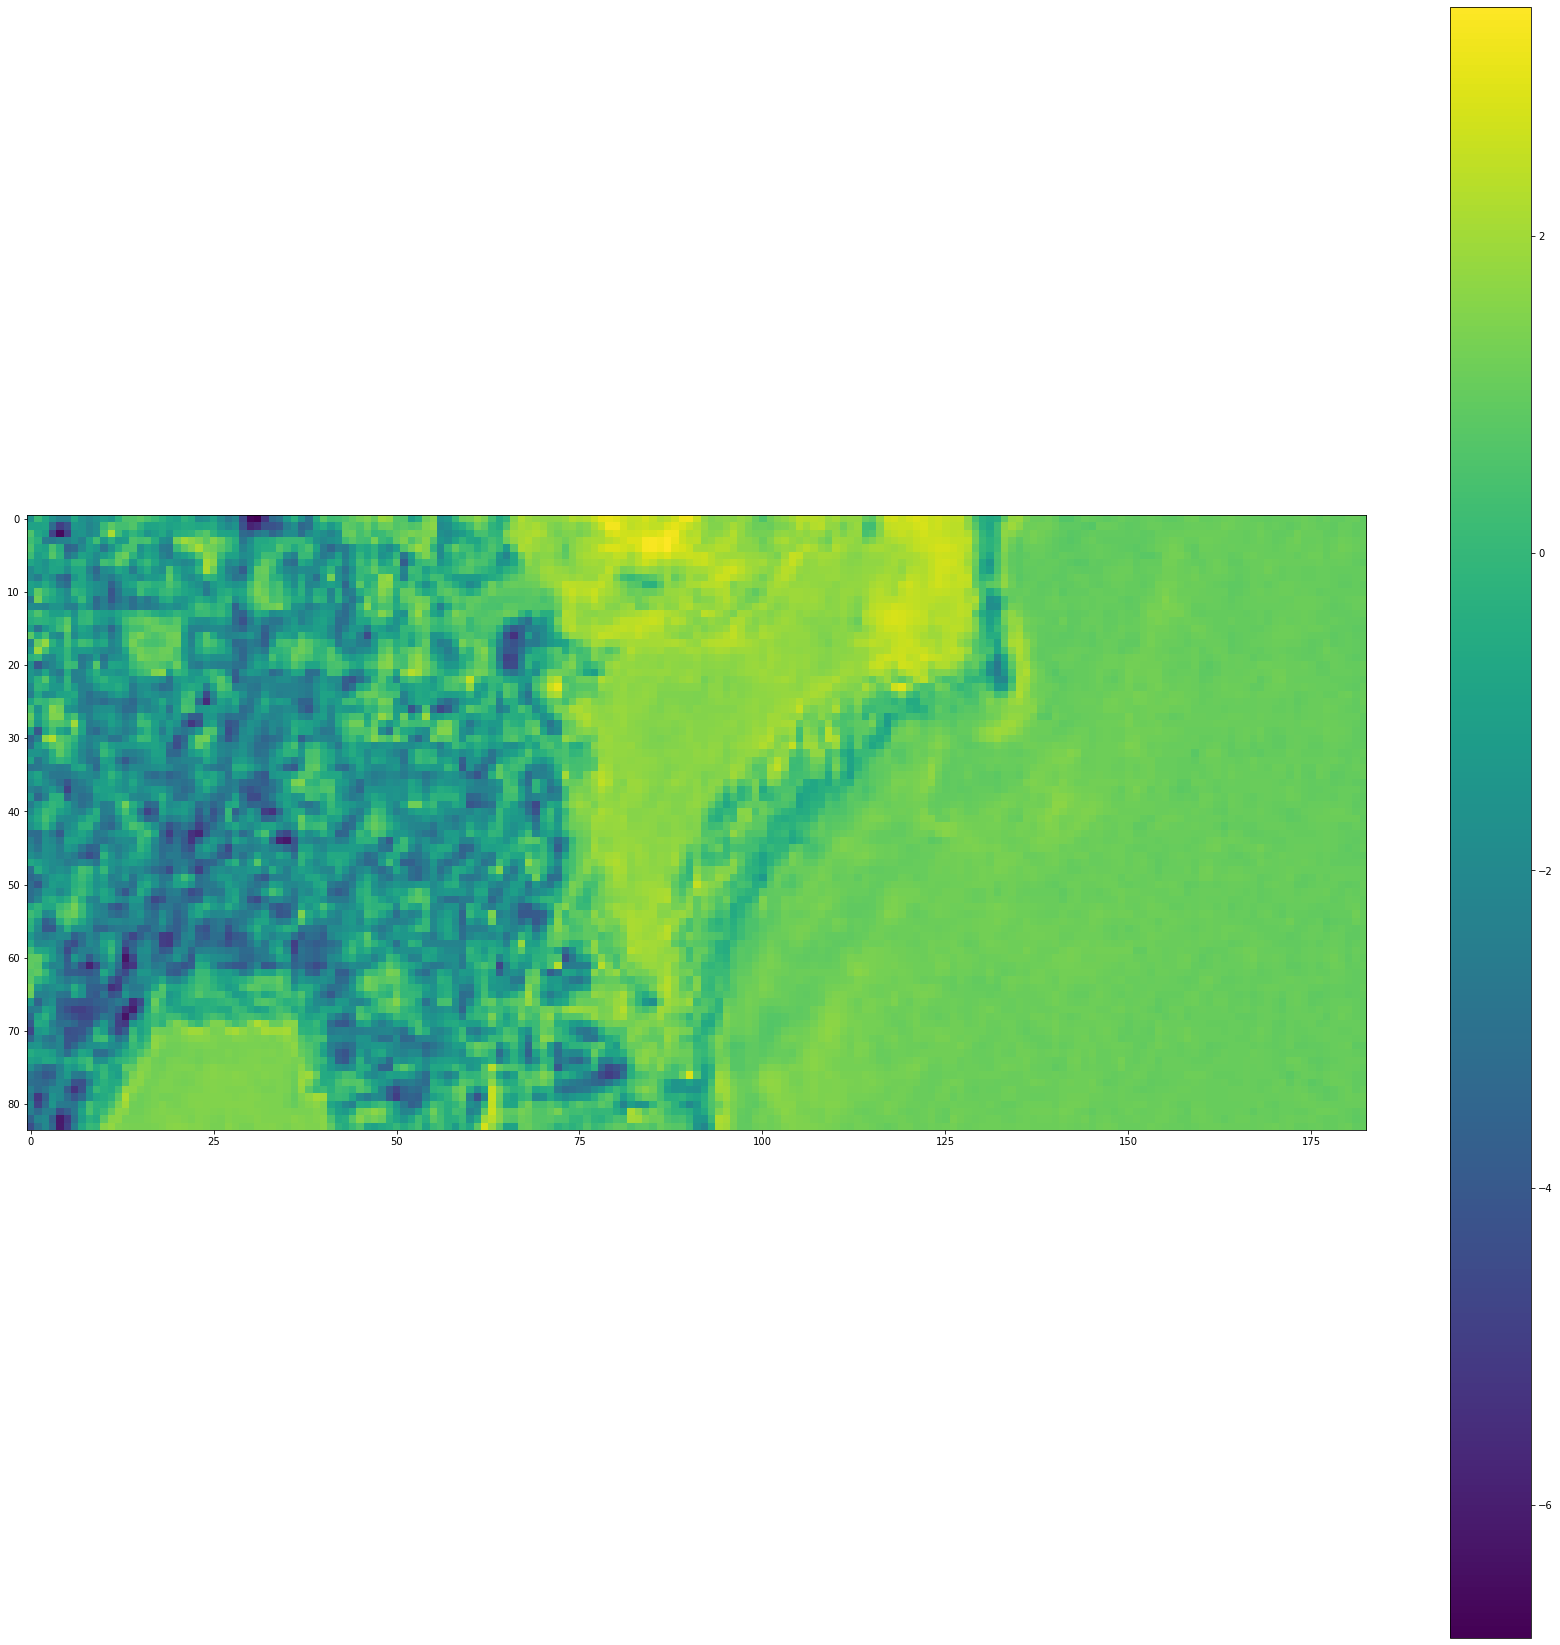

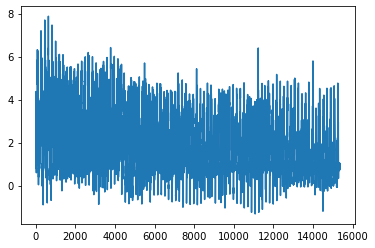

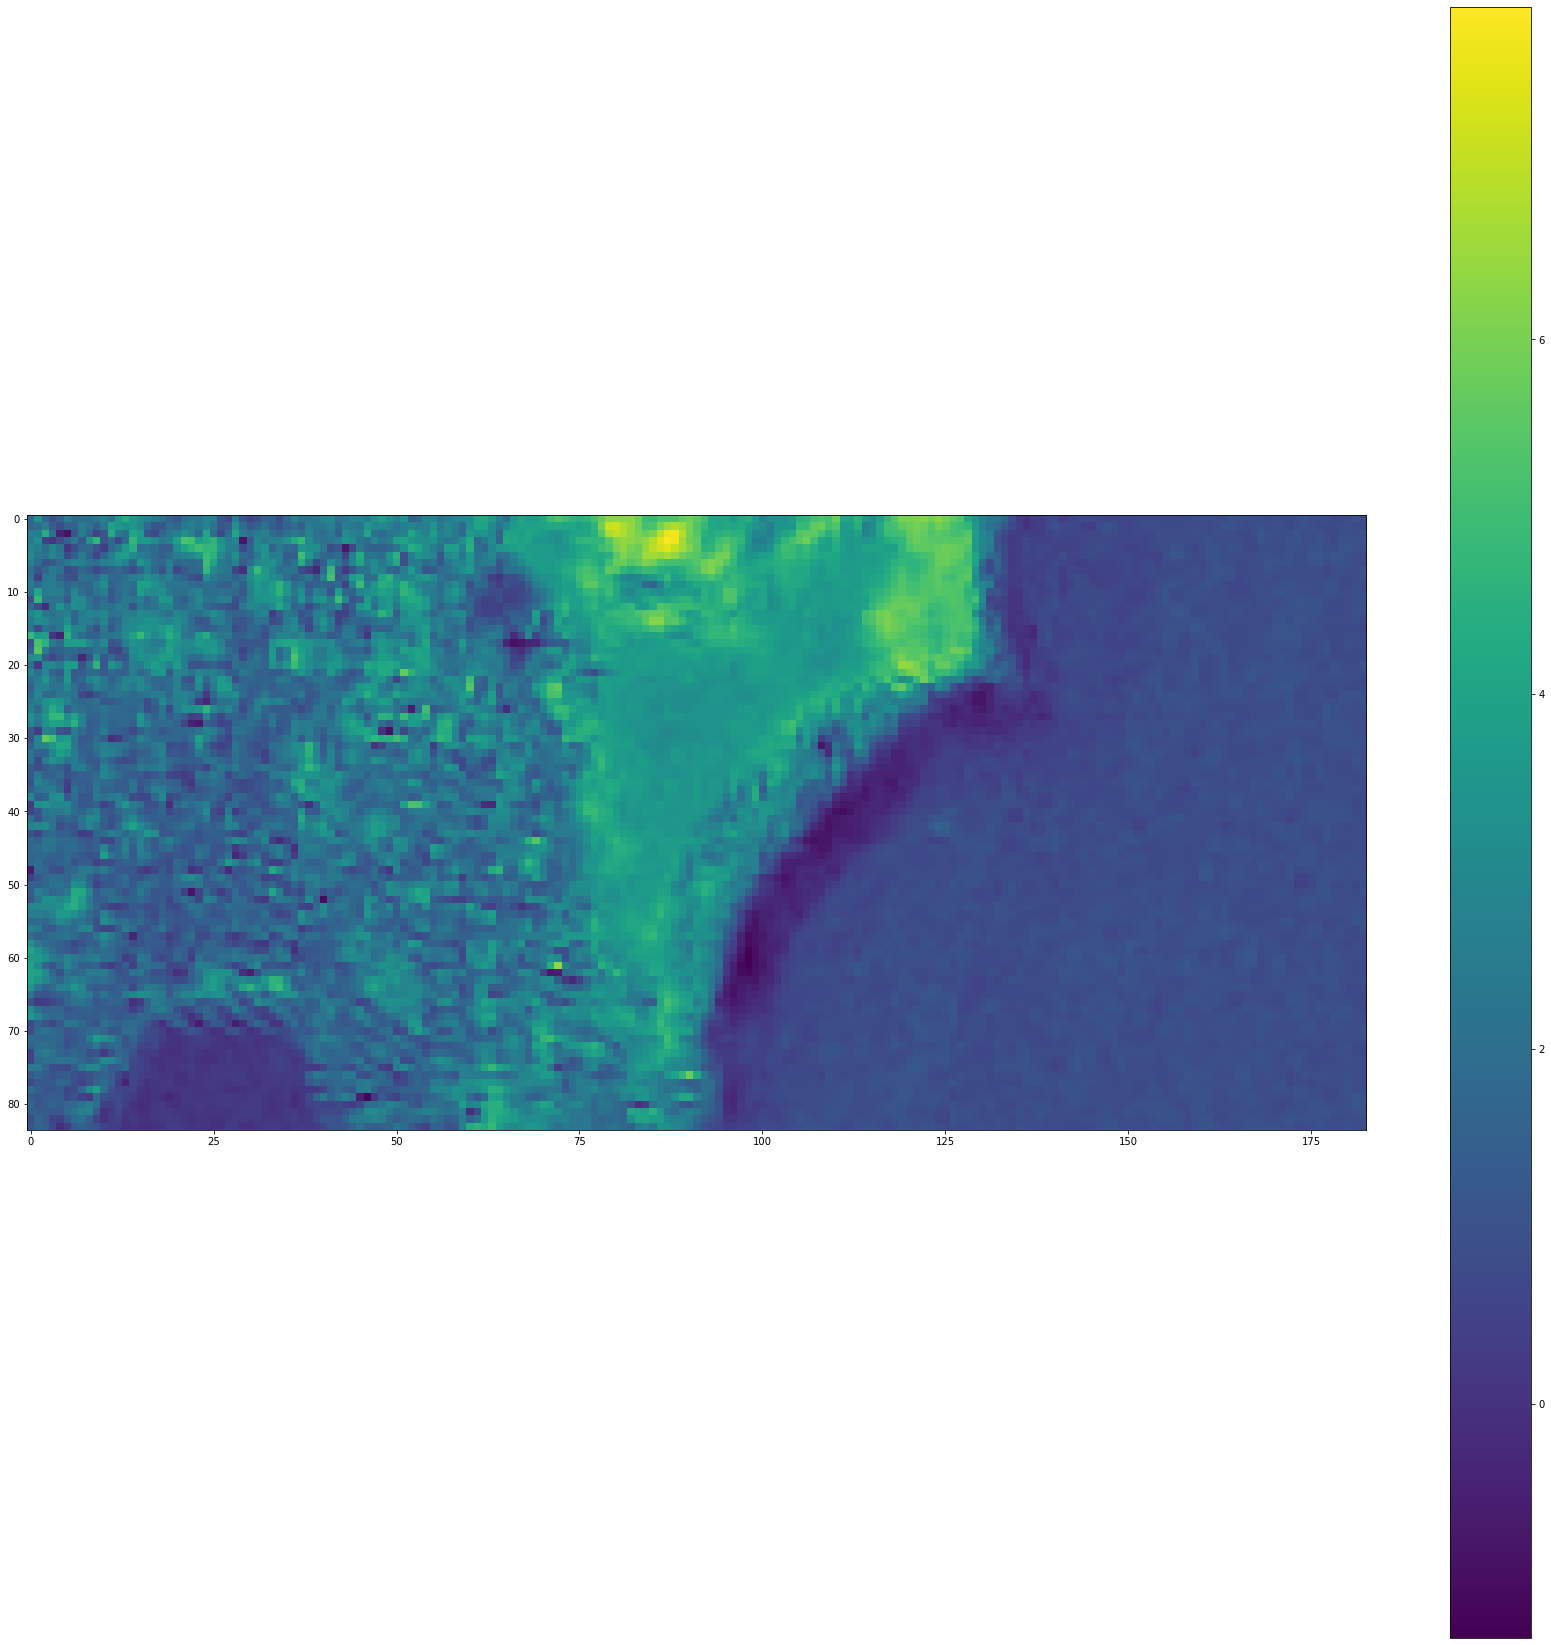

In [97]:
# prediction on img1
index_list = [1,2,3,7,8]
ind_all = [0, m, 0, n]
img_abundance = predict_abundance(band_arrays, index_list, ind_all, plastic_signature_PLP, sea_sign_PLP)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


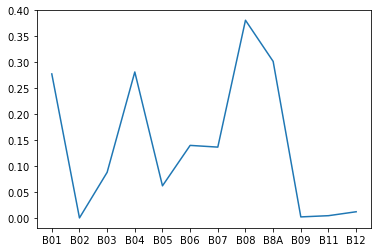

In [160]:

print(labels)
clusters_center = kmeans.cluster_centers_

diff = abs(clusters_center[0]-clusters_center[1])
diff_bis = abs(clusters_center[1]/(max(clusters_center[1]))-clusters_center[0]/(max(clusters_center[0])))
plt.plot(['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],diff_bis)
# plt.plot(['B02','B03','B04','B08','B8A'],diff_bis)

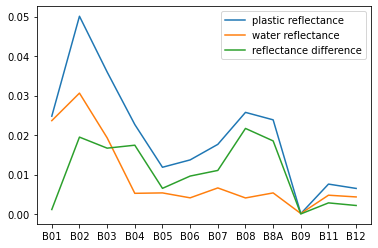

In [161]:
plt.plot(['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],clusters_center[1], label='plastic reflectance')
plt.plot(['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],clusters_center[0], label='water reflectance')
plt.plot(['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],diff, label='reflectance difference')
plt.legend()

In [162]:
img_labels=labels.reshape((ind[1]-ind[0],ind[3]-ind[2]))


## Tests img 2

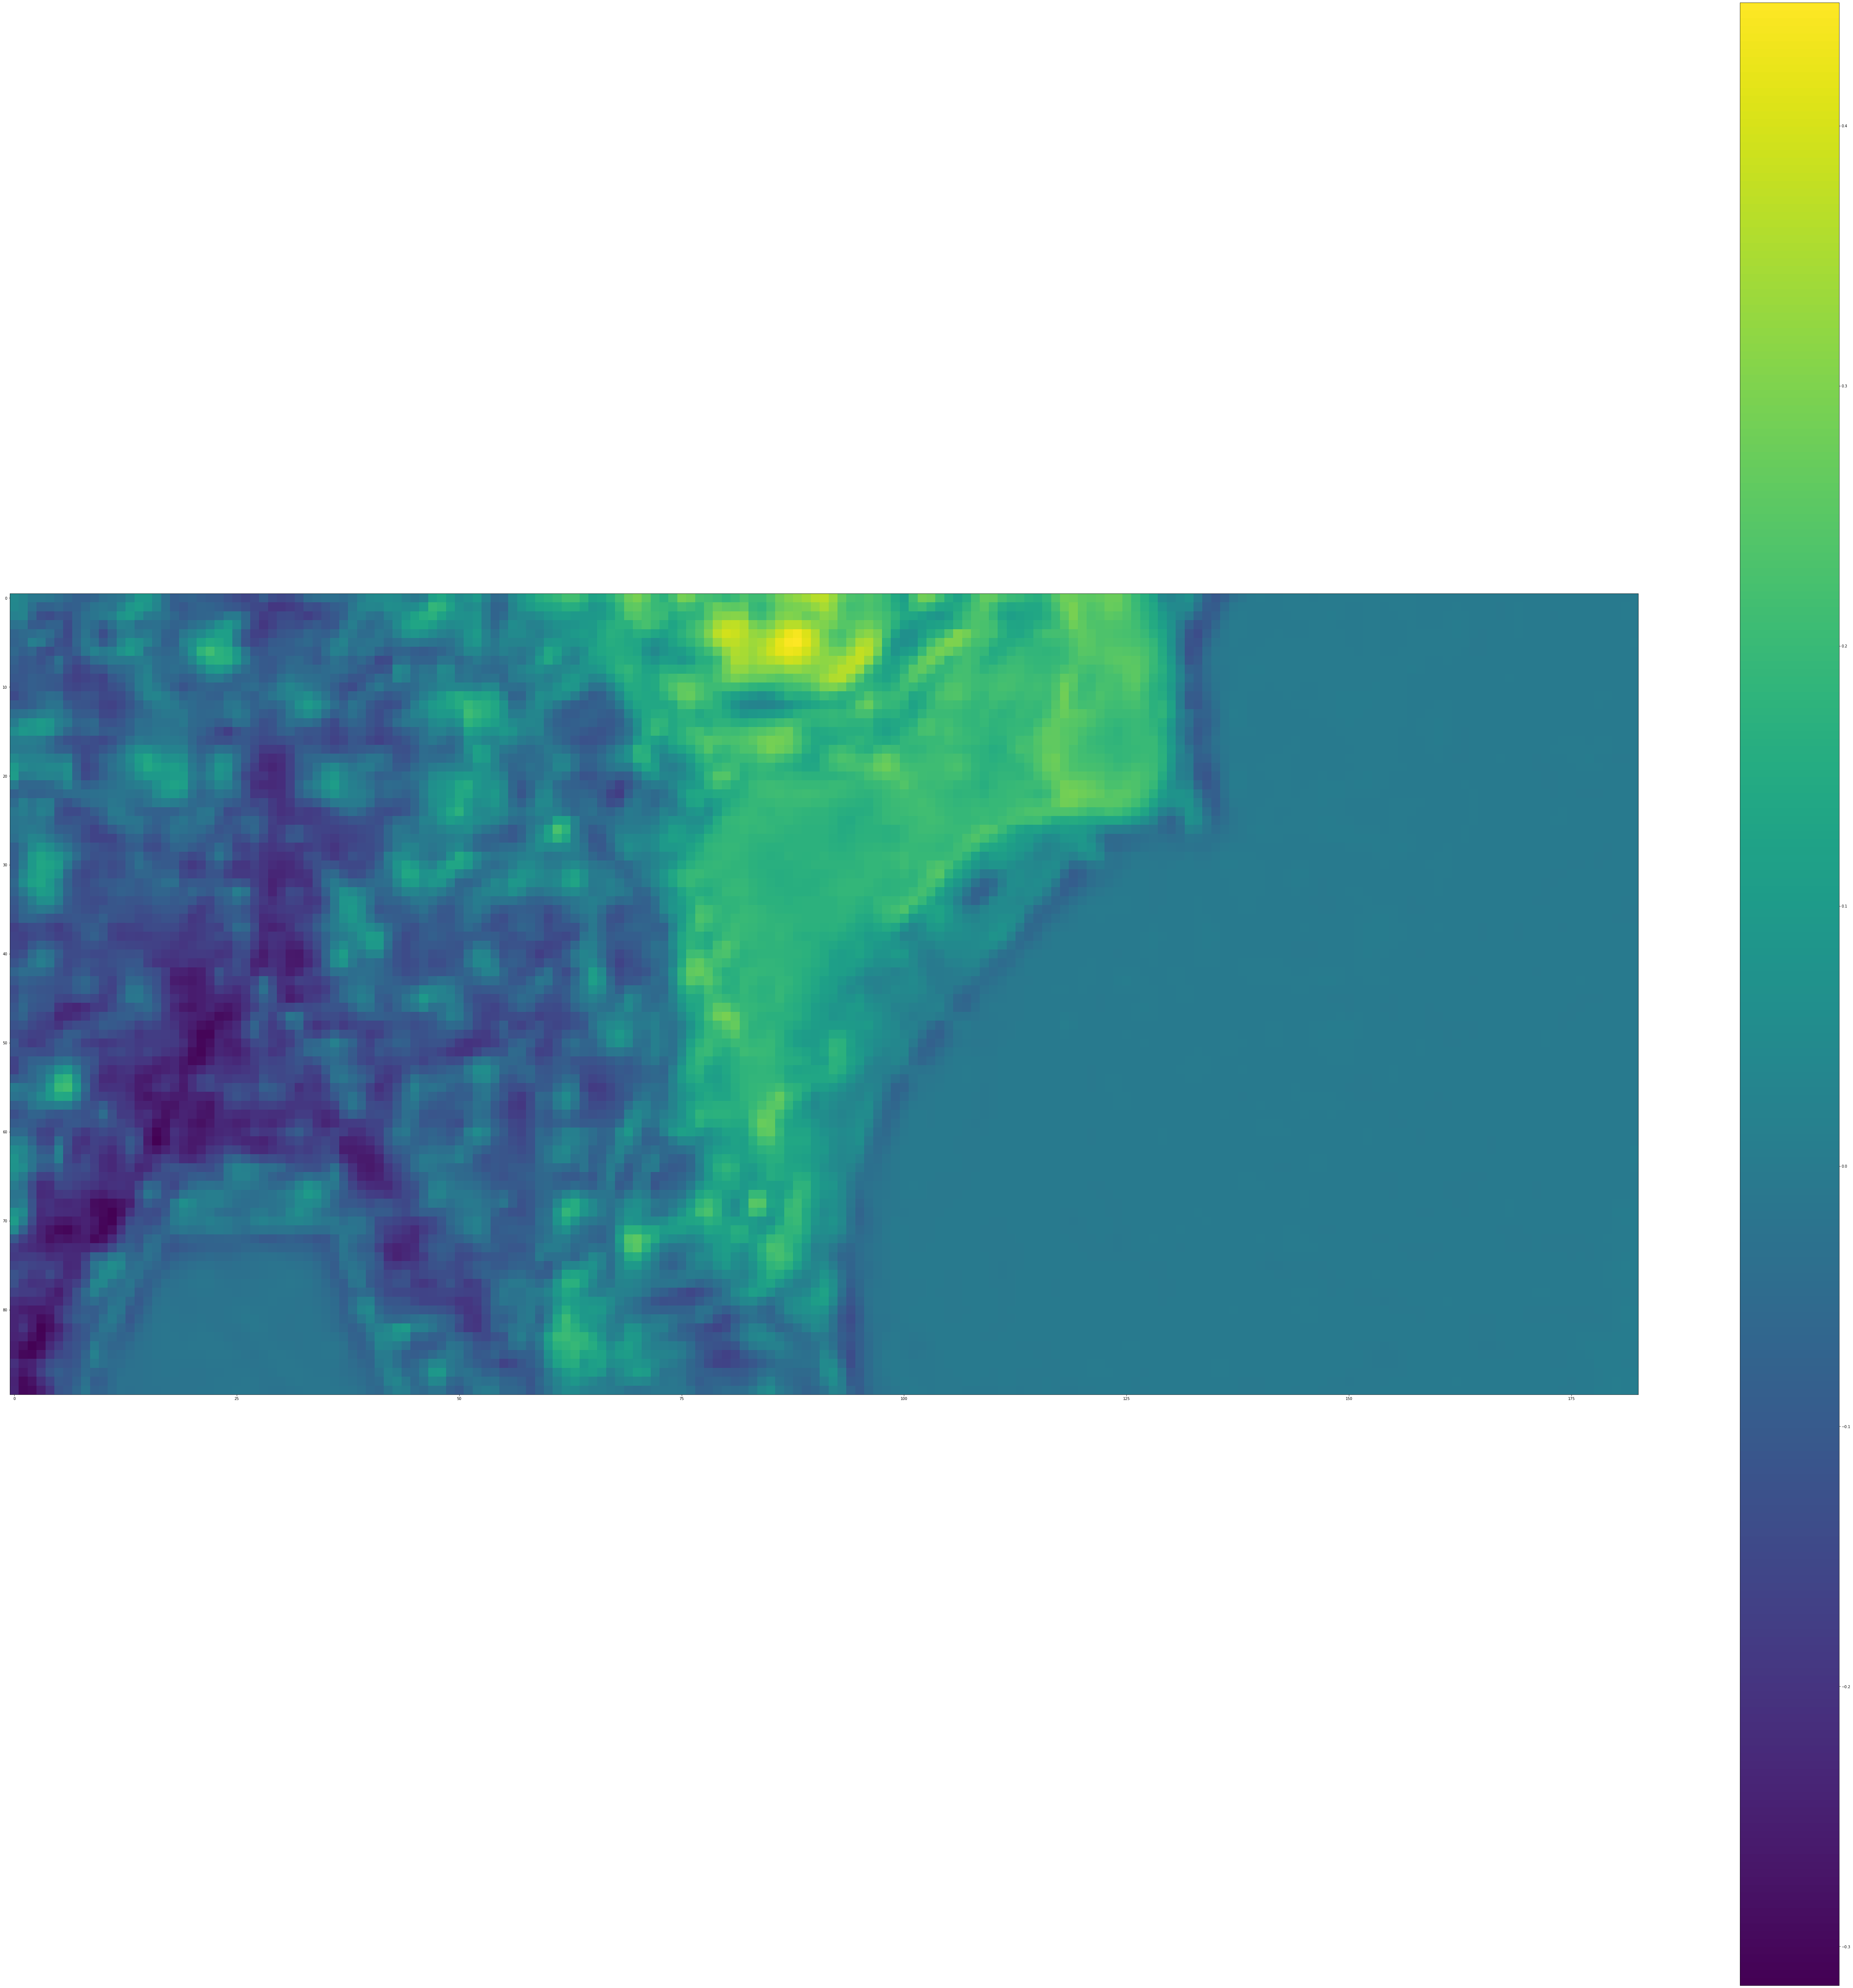

90 183


In [102]:
# get the spectral images
img_bands2 = utils.get_band(bands,img2)

# transorfm the dict into an array

band_arrays2 = from_dict_to_array(img_bands2)

# plot the index

# FDI
FDI2 = utils.get_FDI(img2)
plt.figure(figsize = (100,100))
plt.imshow(FDI2)
plt.colorbar()
plt.show()
# utils.plot_index(FDI2[20:70, 30:100])

# RNDVI
# RNDVI = utils.get_RNDVI(img1)
# utils.plot_index(RNDVI)

# size img
m2,n2 = FDI2.shape
print(m2,n2)

In [108]:
# prediction on a part of img1
ind2 = [40,70, 120,183]
index_list2 = [1,2,3,7,8] #[1,2,3,7,8]
img_abundance = predict_abundance(band_arrays2, index_list2,ind2,  plastic_signature_PLP, sea_sign_PLP)

IndexError: list index out of range

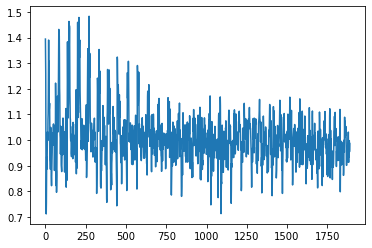

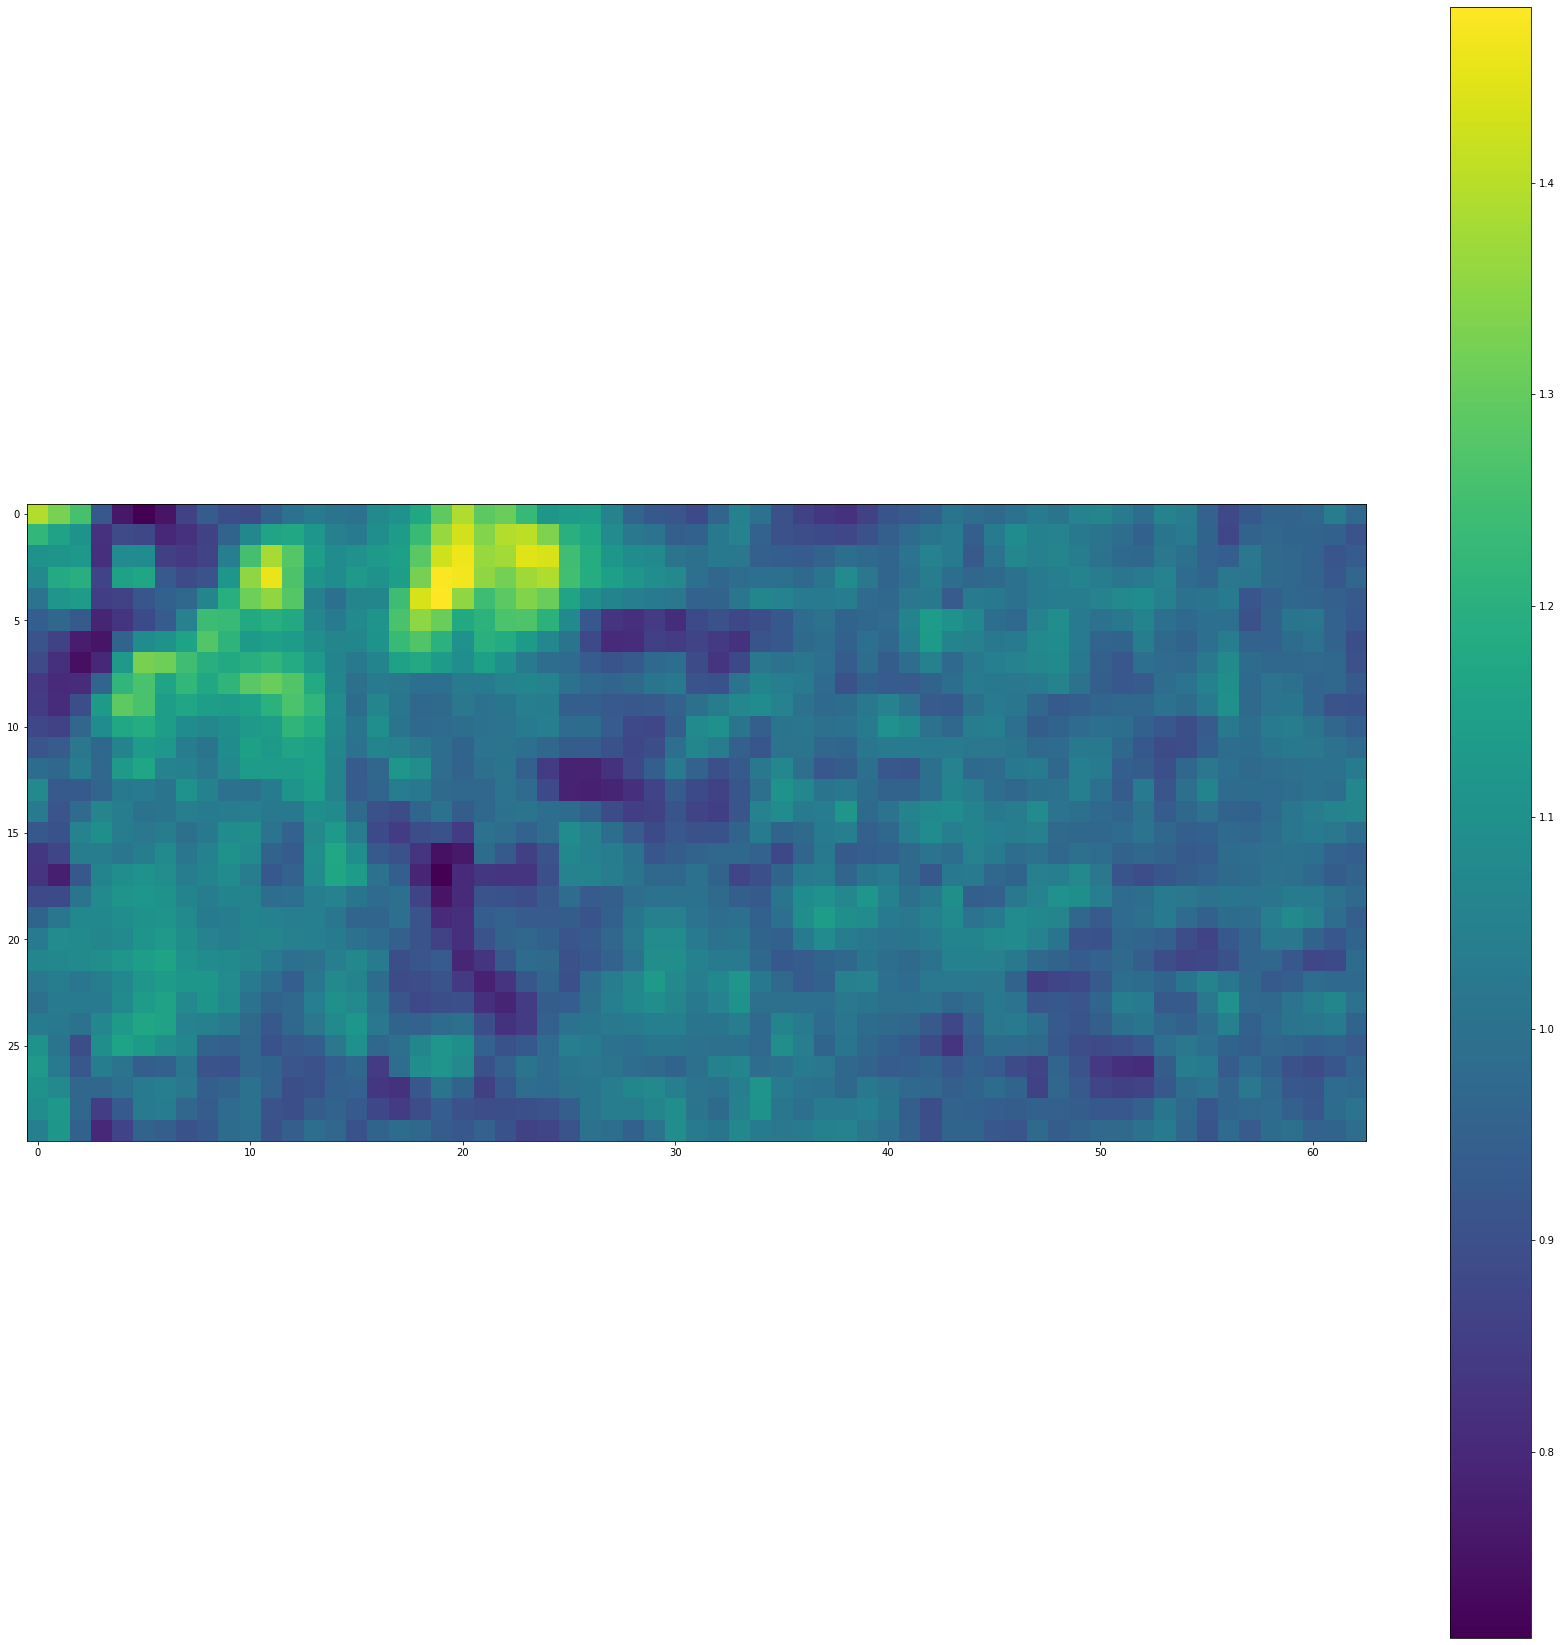

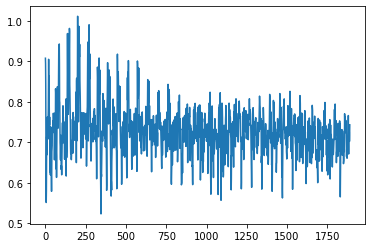

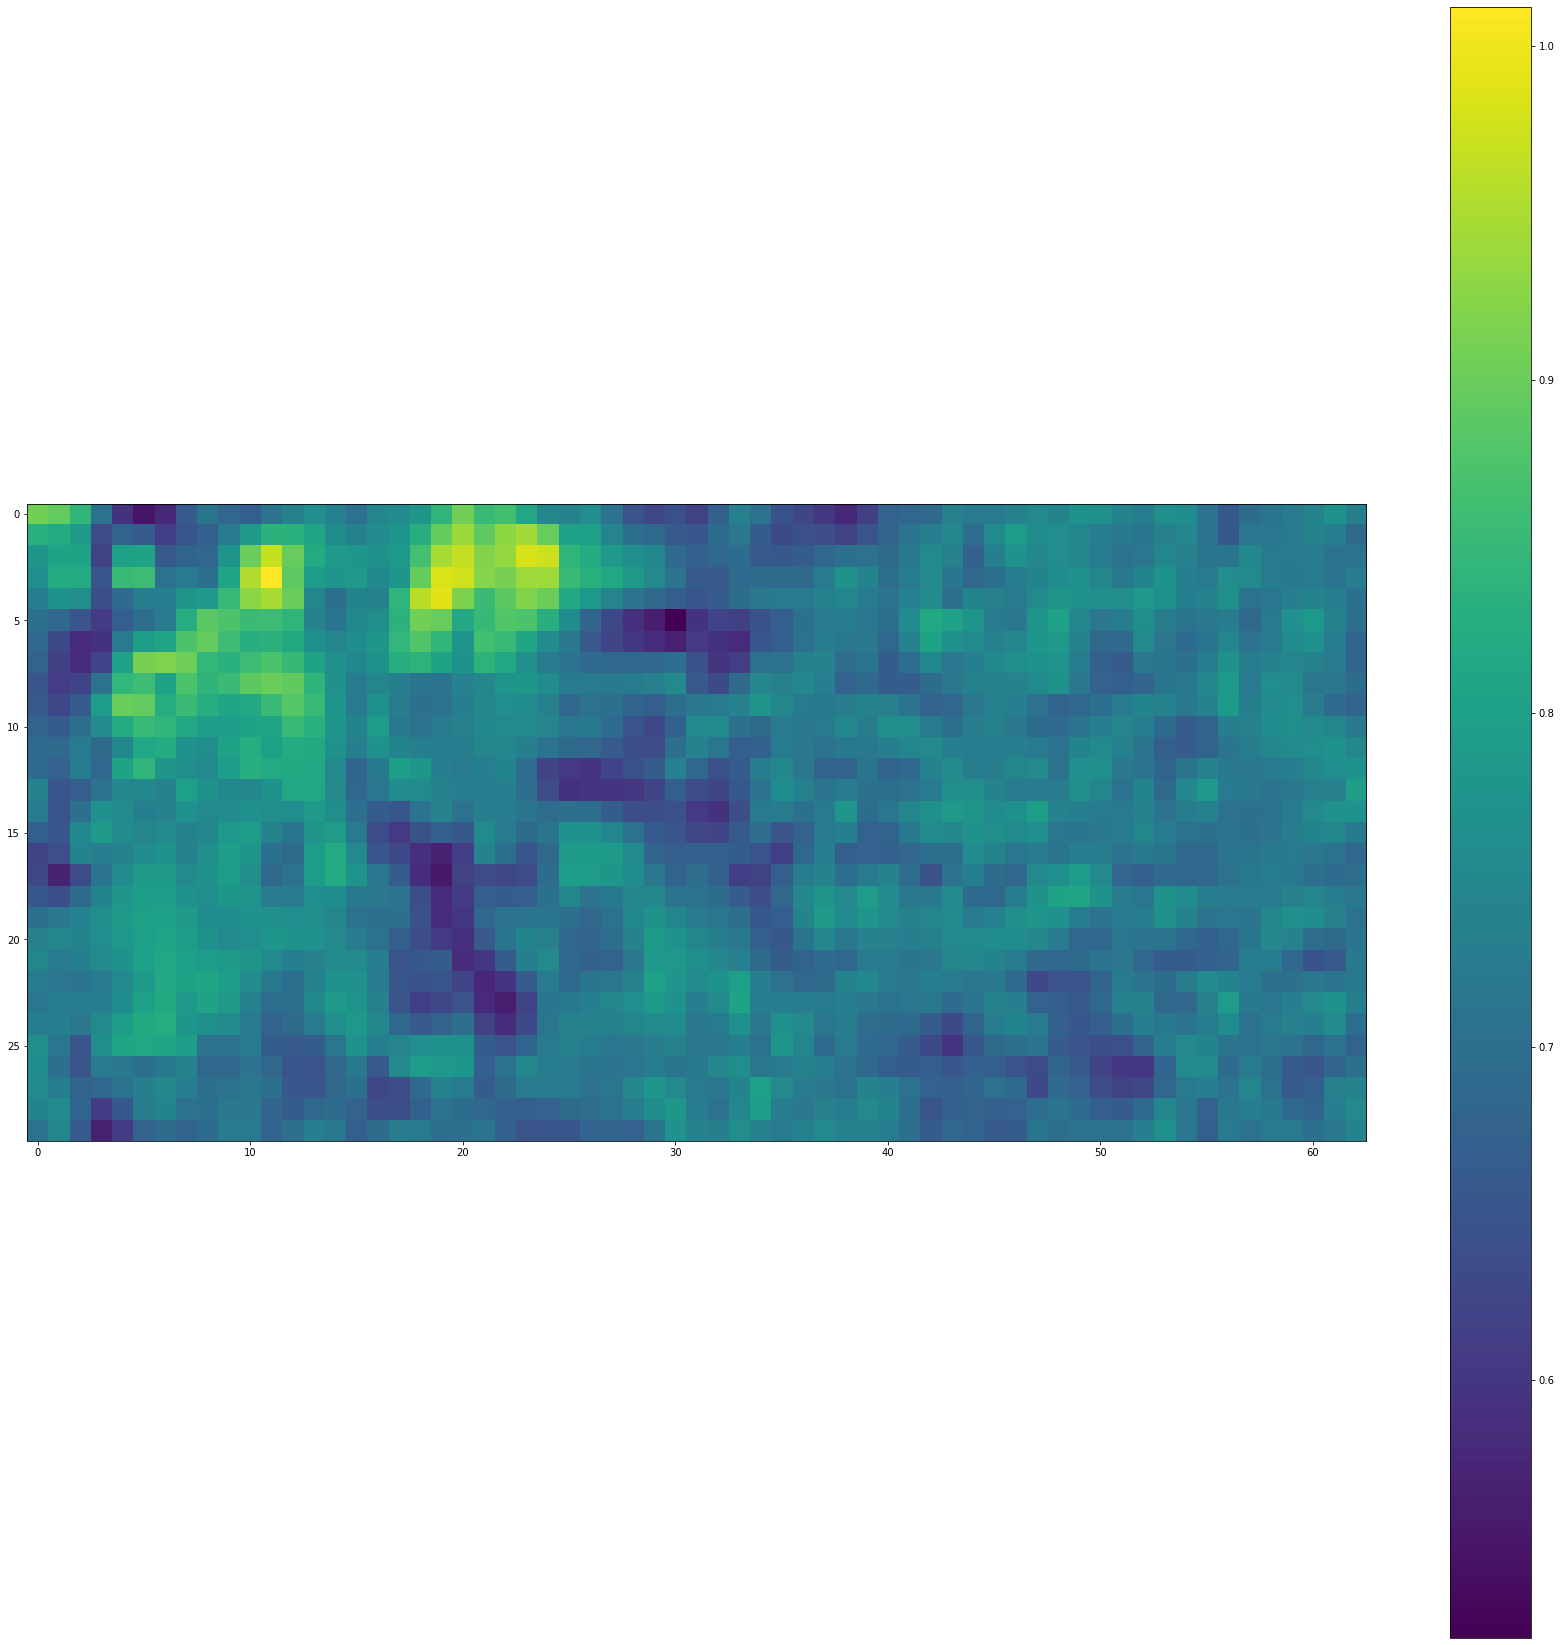

In [109]:
img_abundance = predict_abundance(band_arrays2, index_list2,ind2,  plastic_signature1, sea_sign1)

[3 3 3 ... 2 2 2]
3
3


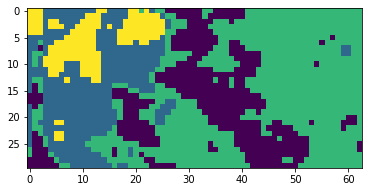

In [112]:
nb_clust = 4
plastic_signature2, sea_sign2 = plastic_signature_kmeans(band_arrays2, ind2,nb_clust)